The 2019 Parlimentary elections data is archived in the ECI website as PDF images. Here is the code for ocr, extraction and cleaning the data.

Note: The image recongition code runs faster with GPU

#Prereq

Install ocr, pdf to image covertor and other useful modules

In [1]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 0s (1,766 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [2]:
!pip install pdf2image
!pip install easyocr
!pip3 install pickle5

     |████████████████████████████████| 63.2MB 62kB/s 
     |████████████████████████████████| 133kB 15.4MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219252 sha256=cb6cb3a36add7f925df74ccc0e852fc08f6fa85405b6113e5b2b944c4bad8a4e
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [3]:
from pdf2image import convert_from_path
import easyocr
import numpy as np
import pandas as pd
from IPython.display import display, Image
import os
import pickle
import csv
import re

In [4]:
#Setting for notebook
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.width = None
pd.options.display.max_colwidth = None
%load_ext google.colab.data_table

from IPython.display import HTML, display

def my_css():
   display(HTML("""<style>table.dataframe td{white-space: nowrap;}</style>"""))

get_ipython().events.register('pre_run_cell', my_css)

In [5]:
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


#Helper functions

Helper function to load and save dict files

In [6]:
!mkdir data
def save_obj(obj, name):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

#Downloading the data

Downloading the PDF files from the website. The PDF files are available in the ECI website https://www.elections.tn.gov.in/GELS2019_Form21E.aspx 

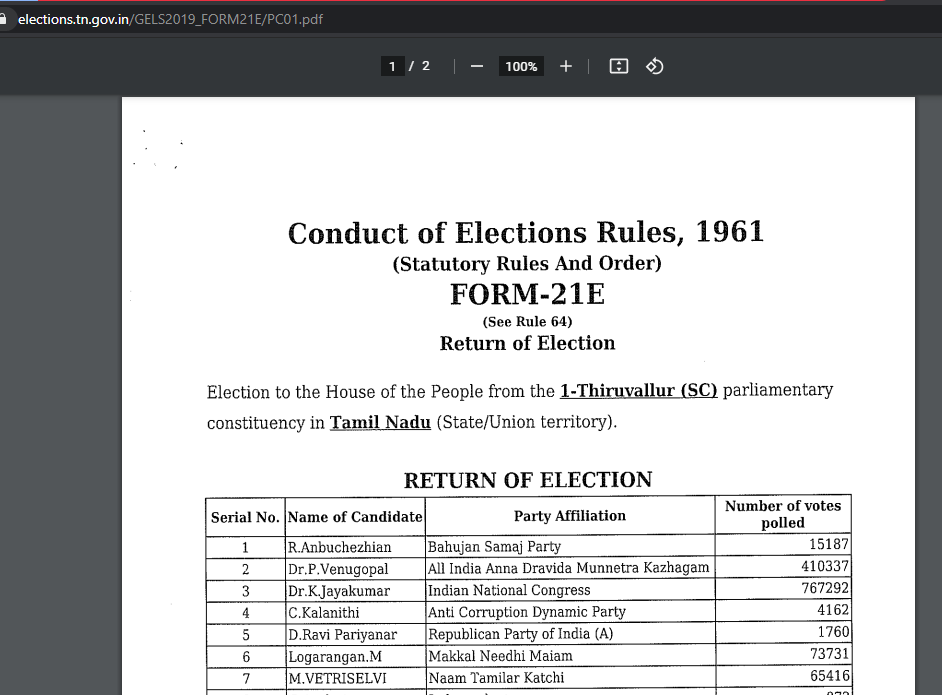

In [7]:
%cd /content/
!mkdir PDFfiles
%cd /content/PDFfiles

/content
/content/PDFfiles


In [8]:
for i in range(1, 10):
  url= 'https://www.elections.tn.gov.in/GELS2019_FORM21E/PC0' + str(i) + '.pdf'
  os.system('wget %s' %url)
for i in range(10, 40):
  url= 'https://www.elections.tn.gov.in/GELS2019_FORM21E/PC' + str(i) + '.pdf'
  os.system('wget %s' %url)

In [9]:
data = []
for filename in os.listdir('/content/PDFfiles'):
    if filename.endswith("pdf"): 
        data.append(filename)
data.sort()
print(data)

['PC01.pdf', 'PC02.pdf', 'PC03.pdf', 'PC04.pdf', 'PC05.pdf', 'PC06.pdf', 'PC07.pdf', 'PC08.pdf', 'PC09.pdf', 'PC10.pdf', 'PC11.pdf', 'PC12.pdf', 'PC13.pdf', 'PC14.pdf', 'PC15.pdf', 'PC16.pdf', 'PC17.pdf', 'PC18.pdf', 'PC19.pdf', 'PC20.pdf', 'PC21.pdf', 'PC22.pdf', 'PC23.pdf', 'PC24.pdf', 'PC25.pdf', 'PC26.pdf', 'PC27.pdf', 'PC28.pdf', 'PC29.pdf', 'PC30.pdf', 'PC31.pdf', 'PC32.pdf', 'PC33.pdf', 'PC34.pdf', 'PC35.pdf', 'PC36.pdf', 'PC37.pdf', 'PC38.pdf', 'PC39.pdf']


#Extracting text from pdf (images)

Use easy OCR to extract text from the PDF images

In [10]:
bounded_data = {}
thedf = {}
listdf = {}

In [11]:
for i in data[0:2]:
  #Convert the PDF to images
  images = convert_from_path('/content/PDFfiles/' + i)
  if len(images) == 1:
    bounded_data[i] = reader.readtext(np.array(images[0]), min_size=0, slope_ths=0.2, ycenter_ths=0.7, height_ths=0.6, width_ths=0.8,decoder='beamsearch', beamWidth=10)
  if len(images) == 2:

    bounds1 = reader.readtext(np.array(images[0]), min_size=0, slope_ths=0.2, ycenter_ths=0.7, height_ths=0.6, width_ths=0.8,decoder='beamsearch', beamWidth=10)
    bounds2 = reader.readtext(np.array(images[1]), min_size=0, slope_ths=0.2, ycenter_ths=0.7, height_ths=0.6, width_ths=0.8,decoder='beamsearch', beamWidth=10)
    bounded_data[i] = bounds1 + bounds2

  theshortlist = []
  for j in range(0, len(bounded_data[i])):
    theshortlist.append(bounded_data[i][j][1])
  listdf[i] = theshortlist
  thedf[i] = ' '.join(theshortlist)
print(len(listdf))

39


In [12]:
%cd /content

/content


In [13]:
save_obj(listdf, 'listdf')
save_obj(thedf, 'thedf')

#Creating text file dump for manual data correction

In [14]:
%cd /content
!mkdir TxtFiles
%cd /content/TxtFiles

for key, val in thedf.items():
  text_file = open(key + ".txt", "w")
  n = text_file.write(val)
  text_file.close()

/content
/content/TxtFiles


In [16]:
Texts = []

for filename in os.listdir('/content/TxtFiles'):
    if filename.endswith("txt"): 
        Texts.append(filename)
Texts.sort()
print(Texts)

['PC01.pdf.txt', 'PC02.pdf.txt', 'PC03.pdf.txt', 'PC04.pdf.txt', 'PC05.pdf.txt', 'PC06.pdf.txt', 'PC07.pdf.txt', 'PC09.pdf.txt', 'PC10.pdf.txt', 'PC11.pdf.txt', 'PC12.pdf.txt', 'PC13.pdf.txt', 'PC14.pdf.txt', 'PC15.pdf.txt', 'PC16.pdf.txt', 'PC17.pdf.txt', 'PC18.pdf.txt', 'PC19.pdf.txt', 'PC20.pdf.txt', 'PC21.pdf.txt', 'PC22.pdf.txt', 'PC23.pdf.txt', 'PC24.pdf.txt', 'PC25.pdf.txt', 'PC26.pdf.txt', 'PC27.pdf.txt', 'PC28.pdf.txt', 'PC29.pdf.txt', 'PC30.pdf.txt', 'PC31.pdf.txt', 'PC32.pdf.txt', 'PC33.pdf.txt', 'PC34.pdf.txt', 'PC35.pdf.txt', 'PC36.pdf.txt', 'PC37.pdf.txt', 'PC38.pdf.txt', 'PC39.pdf.txt']


#Extracting structured data from text files after manual corrections

Manualy open the text files and make corrections


1.   Remove additional text from top and bottom including page nummbers
2.   Some text might have run to the second row
3.   Remove lines which were recognized as [, ], | etc
4.   Add missing or unrecognized numbers
5.   Add const results and details for easy recognition

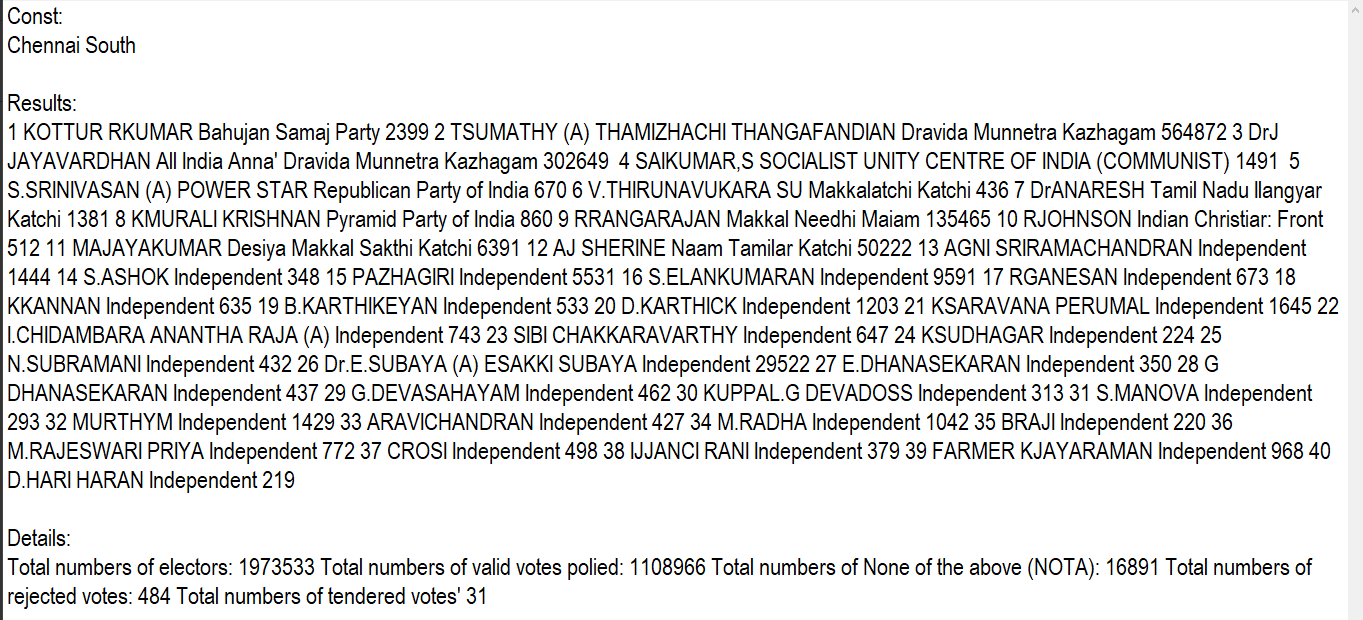




In [17]:
Results_details = {}

for text in Texts:
  string = open(text, "r").read()
  badchar = string[6:7]
  string = string.replace(badchar, ' ')

  m1 = re.search('Const:(.+?)Results:', string)
  if m1:
    const = m1.group(1)
  m2 = re.search('Results:(.+?)Details:', string)
  if m2:
    result_val = m2.group(1)
    check = re.split('(\d+)', result_val)
    values =[' ', '  ']
    for val in values:
      check = [i for i in check if i != val]
    results = []
    for i in range(0, len(check)-2):
      if i%3 == 0:
        results.append([const, check[i], check[i + 1],check[i + 2]])

  det = string.split('Details:')[1].lower()

  det = det.replace(' ', '')
  det = det.replace('\n', '')
  det = det.replace(':', '')
  det = det.replace('"', '')
  det = det.replace("'", '')
  det = det.replace(",", '')
  det = det.replace("nonefthe", 'noneofthe')
  det = det.replace('noneoftheabove(nota)', 'nota')
  det = det.replace('noneoftheabove', 'nota')
  det = det.replace('numbers', 'number')
  det = det.replace('votes', 'vote')
  det = det.replace("polied", 'polled')
  det = det.replace("ttotal", 'total')
  det = det.replace("votefornota", 'ofnota')
  det = det.replace("poled", 'polled')
  det = det.replace("ofof", 'of')

  thedetailslist = re.split('(\d+)', det)
  details = {}
  for i in range(0, len(thedetailslist)-1):
    if i%2 == 0:
      details[thedetailslist[i]] = thedetailslist[i + 1]
  Results_details[text]  = {'const':const, 'results':results, 'details':details}

In [18]:
%cd /content
save_obj(Results_details, 'Results_details')

/content


Run this code repetitively until all data is neatly arranged. Make manual correction in the text files where the pattern is breaking

In [19]:
for text in Texts:
	print(text)
	for result in Results_details[text]['results']:
		print(result)

PC01.pdf.txt
[' Thiruvallur  ', '1', ' RAnbuchezhian Bahujan Samaj Party ', '15187']
[' Thiruvallur  ', '2', ' DrP Venugopal All India Anna Dravida Munnetra Kazhagam ', '410337']
[' Thiruvallur  ', '3', ' DrK Jayakumar Indian National Congress ', '767292']
[' Thiruvallur  ', '4', ' C Kalanithi Anti Corruption Dynamic Party ', '4162']
[' Thiruvallur  ', '5', ' DRavi Pariyanar Republican Party of India (A) ', '17601']
[' Thiruvallur  ', '6', ' Logarangan M Makkal Needhi Maiam ', '73731']
[' Thiruvallur  ', '7', ' M.VETRISELVI Naam Tamilar Katchi ', '65416']
[' Thiruvallur  ', '8', ' G.Arulraj Independent ', '872']
[' Thiruvallur  ', '9', ' DAnandaraj Independent ', '789']
[' Thiruvallur  ', '10', ' KKamalanathan Independent ', '7051']
[' Thiruvallur  ', '11', ' V.Gunasekaran Independent ', '9081']
[' Thiruvallur  ', '12', ' KChandrasekar Independent ', '762']
[' Thiruvallur  ', '13', ' S.Sargunam Independent ', '723']
[' Thiruvallur  ', '14', ' CBharath Independent ', '1977']
[' Thiruval

#Compiling Parlimentary cosntituency wise data

In [20]:
all_results = []
for i in Results_details.values():
  for j in i['results']:
    all_results.append(j)

In [21]:
Parties = ['Peoples Party of India (SECULAR)', 'NOTA', 'Anaithu Makkal Katchi', 'Akila India Vallalar Peravai', 'Tamizhaga Murpokku Makkal Katchi', 'Ambedkarite Party of India', 'All India Uzhavargal Uzhaippalargal Katchi', 'Vivasayigal Makkal Munnetra Katchi', 'AHIMSA SOCIALIST PARTY', 'ULZATPALI MAKKAL KATCHY', 'Anaithu Makkal Puratchi Katchi', 'Desiya Uzhavar Uzhaipalar Kazhagam', 'Indian New Congress Party', 'Desiya Uzhavar Uzhaipalar Kazhagam', 'Ezhuchi Tamilargal Munnetra Kazahagam', 'Agila India Makkal Kazhagam', 'Purvanchal Janta Party (Secular)', 'Ilantamilar Munnani Kazhagam', 'Anaithu Makkal Puratchi Katchi', "All Pensioners' Party", 'MAKKAL SANANAYAGA KUDIYARASU KATCHI', 'Samajwadi Forward Bloc', 'Ulzaipali Makkal Katchi', 'ALL INDIA PURATCHI THALAIVAR MAKKAL MUNNETRA KAZHAGAM', 'AHILA INDIA DHAYAGA MAKKAL MUNNETRA KATCHI', 'Purvanchal Janta Party (Secular)', 'Tamil Telugu National Party', 'Universal Brotherhood Movement', 'United States of India Party','Pyramid Party of India', 'TAMIL MAANILA CONGRESS','TamilNadu Ilangyar Katchi','Naam Indiar Party', 'Anti Corruption Dynamic Party','Tamil Nadu Ilangyar Katchi', 'Makkal Needhi Maiam','Bharatiya Janata Party','Bahujan Samaj Party','Communist Party of India','Communist Party of India  (Marxist)','Indian National Congress','Nationalist Congress Party','All India Forward Bloc','All India Majlis-E-Ittehadul Muslimeen','Indian Union Muslim League','Janata Dal  (Secular)','Janata Dal  (United)','Jammu & Kashmir National Panthers Party','Lok Jan Shakti Party','Pattali Makkal Katchi','Rashtriya Janata Dal','Shivsena','Samajwadi Party','All India Anna Dravida Munnetra Kazhagam','Desiya Murpokku Dravida Kazhagam','Dravida Munnetra Kazhagam','Akhil Bharat Hindu Mahasabha','All India Forward Bloc  (Subhasist)','Akhila India Jananayaka Makkal Katchi (Dr. Isaac)','All India Pattali Munnetra Katchi','All India Women United Party','Anaithu Makkal Munnetra Kazhagam','ALL PENSIONERS PARTY','Anbu Udhayam Katchi','Christian Democratic Front','Communist Party of India  (Marxist-Leninist)  (Liberation)','Communist Party of India (Marxist-Leninist) Red Star','Democratic Corruption Liberation Front','Desa Makkal Munnetrak Kazhgam','Desiya Makkal Sakthi Katchi','Eluchi Desam Party','Ezhuchi Tamilargal Munnetra Kazhagam','Forward Democratic Labour Party','The Future India Party',"Gandhiyan People's Party",'Gandhiya Makkal Iyakkam','Gokula Makkal Katchi','Ganasangam Party of India','Indian Christian Front','India Dravida Makkal Munnetra Katchi','Indiya Jananayaka Katchi','India Makkal Munnetra Katchi','Jan Shakti Dal','Jebamani Janata','Kongunadu Makkal Desia Katchi','Makkal Kootamaipu Katchi','Manithaneya Makkal Katchi','Marumalarchi Dravida Munnetra Kazhagam','Makkalatchi Katchi','Makkal Manadu Katchi','Makkal Sananayaga Kudiyarasu Katchi,','Namadhu Makkal Katchi','Naam Tamilar Katchi',"People's Party of India(secular)",'Puthiya Tamilagam','Puratchikara Thozilalar Katchi','Republican Party of India','Republican Party of India (A)','Republican Sena','Rashtriya Samaj Paksha','Rashtriya Janta Party','Samata Party','Samajwadi Samaj Party','Sainik Samaj Party','Socialistic Democratic Party','SOCIAL DEMOCRATIC PARTY OF INDIA','Samuga Makkal Katchi','SOCIALIST UNITY CENTRE OF INDIA (COMMUNIST)','Super Nation Party','Tamizhaga Vaazhvurimai Katchi','Thozhilalar Party','Tamil Maanila Congress (Moopanar)','Tamilar Makkal Katchi','Tamilaga Makkal Munnetra Kazhagam','Tamilaga Sthabana Congress','United Communist Party of India','Ulzaipali Makkal Katchy','Vijaya Bharatha Makkal (People) Party','Viduthalai Chiruthaigal Katchi','Vidiyalai Thedum Indhiyargal Party','Valamaana Tamizhagam Katchi','Valimai Valartchi Indians Party','Welfare Party Of India','Youth And Students Party','Independent','None of the Above']

In [22]:
df = pd.DataFrame(all_results, columns=['Parl Const', 'S. No.', 'Part+Cand', "Total Votes"])
df

,Parl Const,S. No.,Part+Cand,Total Votes
0,Thiruvallur,1,RAnbuchezhian Bahujan Samaj Party,15187
1,Thiruvallur,2,DrP Venugopal All India Anna Dravida Munnetra Kazhagam,410337
2,Thiruvallur,3,DrK Jayakumar Indian National Congress,767292
3,Thiruvallur,4,C Kalanithi Anti Corruption Dynamic Party,4162
4,Thiruvallur,5,DRavi Pariyanar Republican Party of India (A),17601
5,Thiruvallur,6,Logarangan M Makkal Needhi Maiam,73731
6,Thiruvallur,7,M.VETRISELVI Naam Tamilar Katchi,65416
7,Thiruvallur,8,G.Arulraj Independent,872
8,Thiruvallur,9,DAnandaraj Independent,789
9,Thiruvallur,10,KKamalanathan Independent,7051


In [23]:
def ExtractPartyandCand(val):
    check = 1
    for party in Parties:
      if party.lower() in val.lower():
        name = re.sub(party, '', val, flags=re.IGNORECASE)
        check = 0
        return party, name
        break;
    if check == 1:
      return 'Check', 'Check'

df['Party'],  df['Candidate'] = zip(*df['Part+Cand'].apply(ExtractPartyandCand))
df


,Parl Const,S. No.,Part+Cand,Total Votes,Party,Candidate
0,Thiruvallur,1,RAnbuchezhian Bahujan Samaj Party,15187,Bahujan Samaj Party,RAnbuchezhian
1,Thiruvallur,2,DrP Venugopal All India Anna Dravida Munnetra Kazhagam,410337,All India Anna Dravida Munnetra Kazhagam,DrP Venugopal
2,Thiruvallur,3,DrK Jayakumar Indian National Congress,767292,Indian National Congress,DrK Jayakumar
3,Thiruvallur,4,C Kalanithi Anti Corruption Dynamic Party,4162,Anti Corruption Dynamic Party,C Kalanithi
4,Thiruvallur,5,DRavi Pariyanar Republican Party of India (A),17601,Republican Party of India,DRavi Pariyanar (A)
5,Thiruvallur,6,Logarangan M Makkal Needhi Maiam,73731,Makkal Needhi Maiam,Logarangan M
6,Thiruvallur,7,M.VETRISELVI Naam Tamilar Katchi,65416,Naam Tamilar Katchi,M.VETRISELVI
7,Thiruvallur,8,G.Arulraj Independent,872,Independent,G.Arulraj
8,Thiruvallur,9,DAnandaraj Independent,789,Independent,DAnandaraj
9,Thiruvallur,10,KKamalanathan Independent,7051,Independent,KKamalanathan


In [25]:
df.to_csv('Data19.csv')

Open the saved csv files and make corrections to the party name and candidates field:

1.   Check for cells with check value
1.   Check the long party names
2.   Check for parties which have a sub string of another party




In [30]:
data = pd.read_csv('Data19.csv')
data.drop(['Part+Cand', 'Unnamed: 0'], axis=1,inplace=True)
results_2019= data[['Parl Const', 'S. No.', 'Party', 'Candidate', "Total Votes"]]
results_2019.to_csv('Results_summary_for_2019.csv')
results_2019.head(15)

,Parl Const,S. No.,Party,Candidate,Total Votes
0,Thiruvallur,1,Bahujan Samaj Party,RAnbuchezhian,15187
1,Thiruvallur,2,All India Anna Dravida Munnetra Kazhagam,DrP Venugopal,410337
2,Thiruvallur,3,Indian National Congress,DrK Jayakumar,767292
3,Thiruvallur,4,Anti Corruption Dynamic Party,C Kalanithi,4162
4,Thiruvallur,5,Republican Party of India,DRavi Pariyanar (A),17601
5,Thiruvallur,6,Makkal Needhi Maiam,Logarangan M,73731
6,Thiruvallur,7,Naam Tamilar Katchi,M.VETRISELVI,65416
7,Thiruvallur,8,Independent,G.Arulraj,872
8,Thiruvallur,9,Independent,DAnandaraj,789
9,Thiruvallur,10,Independent,KKamalanathan,7051


#Compiling details

Constituency wise details for number of electors, votes polled, NOTA votes , rejected and tendered votes

In [31]:
all_details = {}
for i in Results_details.values():
  all_details[i['const']] = i['details']

In [32]:
df = pd.DataFrame(all_details)
df

,Thiruvallur,Chennai North,Chennai South,Chennai,Sriperumbudur,Kancheepuram,Arakkonam,Krishnagiri,DHARMAPURI,Tiruvannamalai,Arani,VILUPPURAM,Kallakurichi,Salem,Namakkal,Erode,Nilgiris,COIMBATORE,POLLACHI,Dindigul,Karur,Tiruchirappalli,Perambalur,Cuddalore,Chidambaram,Mayiladuthurai,Nagapattinam,Thanjavur,Sivaganga,Madurai,THENI,Virudhunagar,Ramanathapuram,Thoothukkudi,Tenkasi,Tirunelveli,Kanniyakumari
totalnumberofelectors,1946870,1487461,1973533,1332300,2253041,1643656,1500016,1530404,1485804,1470203,1449150,1444335,1528938,1612512,1413246,1529836,1366060,1958577,7520504,1541881,1387286,1508963,1391853,1364038,1480222,1484348,1303060,1461052,1552019,1539026,1561040,1480600,1559740,1427783,1492317,1547800,1501250
totalnumberofvalidvotepolled,1389914,939858,1108966,771628,1406782,1237612,1165881,1141544,1223205,1139412,1126986,1123597,1192799,1238329,1118701,1097723,992570,1227673,7066765,1145869,1093562,1033625,1091442,1034477,1137657,1089012,992745,1044118,1075185,999839,1162803,1057443,1058551,982029,1051513,1028803,1042246
totalnumberofnota,18275,15687,16891,13822,23343,21661,12179,19825,13379,12317,16921,11943,11576,17130,15073,21861,18149,23190,15110,14177,9603,14437,NaN,8725,15535,8231,9463,15105,9283,16187,10686,17292,7595,9234,14056,10958,6131
totalnumberofrejectedvote,76,386,484,307,371,546,1652,904,1260,62,1010,558,560,871,210,5091,330,44,13,885,480,717,393,178,1065,537,712,829,438,1096,1519,1191,777,704,920,40,1050
totalnumberoftenderedvote,0,0,31,15,0,0,0,0,9,0,0,0,0,0,0,0,0,22,0,2,2,0,0,3,5,0,0,1,7,0,0,0,0,19,0,0,14
